In [20]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ExerciseAnswers import Answers

pylab.rcParams['figure.figsize'] = 10, 10

In [21]:
# TODO - scroll to the bottom of this cell and complete the 
#   advance_state method

class CoaxialCopter:
    
    def __init__(self, 
                 k_f = 0.1, # value of the thrust coefficient
                 k_m = 0.1, # value of the angular torque coefficient
                 m = 0.5,   # mass of the vehicle 
                 i_z = 0.2, # moment of inertia around the z-axis
                ):
        
        self.k_f = k_f
        self.k_m = k_m
        self.m = m
        self.i_z = i_z
        
        self.omega_1 = 0.0
        self.omega_2 = 0.0
        self.g = 9.81
        
        # state vector (z, z_dot, psi, psi_dot)
        self.X = np.array([0.0, 0.0, 0.0, 0.0])
        
        # these don't work! need @property methods for them
        self.z   = self.X[0]
        self.z_dot = self.X[1]
        self.psi = self.X[2]        
        self.psi_dot = self.X[3]
        
    
    @property
    def z_dot_dot(self):
        """Calculates current vertical acceleration."""

        f_1 = self.k_f * self.omega_1**2
        f_2 = self.k_f * self.omega_2**2
        f_g = self.m * self.g
        f_total = -f_1 - f_2 + f_g

        acceleration = f_total / self.m 

        return acceleration
    
    @property
    def psi_dot_dot(self): 
        """Calculates current rotational acceleration."""
        cw_torque = self.k_m * self.omega_1 **2
        ccw_torque = self.k_m * self.omega_2 **2

        net_torque = ccw_torque - cw_torque
        angular_acc = net_torque / self.i_z

        return angular_acc
    
    def set_rotors_angular_velocities(self, linear_acc, angular_acc): 
        """
        Sets the turn rates for the rotors so that the drone
        achieves the desired linear_acc and angular_acc.
        """
        term_1 = self.m * (-linear_acc + self.g) /(2 * self.k_f)
        term_2 = self.i_z * angular_acc/(2 * self.k_m)

        omega_1 = math.sqrt(term_1 - term_2)
        omega_2 = math.sqrt(term_1 + term_2)

        self.omega_1 = -omega_1
        self.omega_2 = omega_2

        return self.omega_1, self.omega_2
    
    def advance_state_uncontrolled(self, dt):
        """Advances the state of the drone by dt seconds.
        This method assumes the drone is 'uncontrolled' (zero 
        propeller rotation) and is only influenced by gravity."""
        # update z state first
        z_dot_dot = 9.81
        
        delta_z_dot = dt * z_dot_dot
        self.z_dot += delta_z_dot
        
        delta_z = self.z_dot * dt
        self.z += delta_z
        
        # update psi state
        psi_dot_dot = 0.0
        
        delta_psi_dot = dt * psi_dot_dot
        self.psi_dot += delta_psi_dot
        
        # technically we should restrict psi so it's between 
        # -pi and pi, but we're not going to worry about that now
        delta_psi = self.psi_dot * dt
        self.psi += delta_psi
        
    def advance_state(self,dt):
        """Advances the state of the drone forward by dt seconds"""
        #
        # TODO 
        #  Implement this method! Your implementation may look 
        #  VERY similar to the uncontrolled version of this function.
        
        # update state vector X = X + dt * X_dot
        # note X = [z, z_dot, psi, psi_dot]
        X_dot = np.array([
            self.X[1], # z_dot
            self.z_dot_dot,
            self.X[3], # psi_dot
            self.psi_dot_dot
        ])
        
        self.X = self.X + dt * X_dot


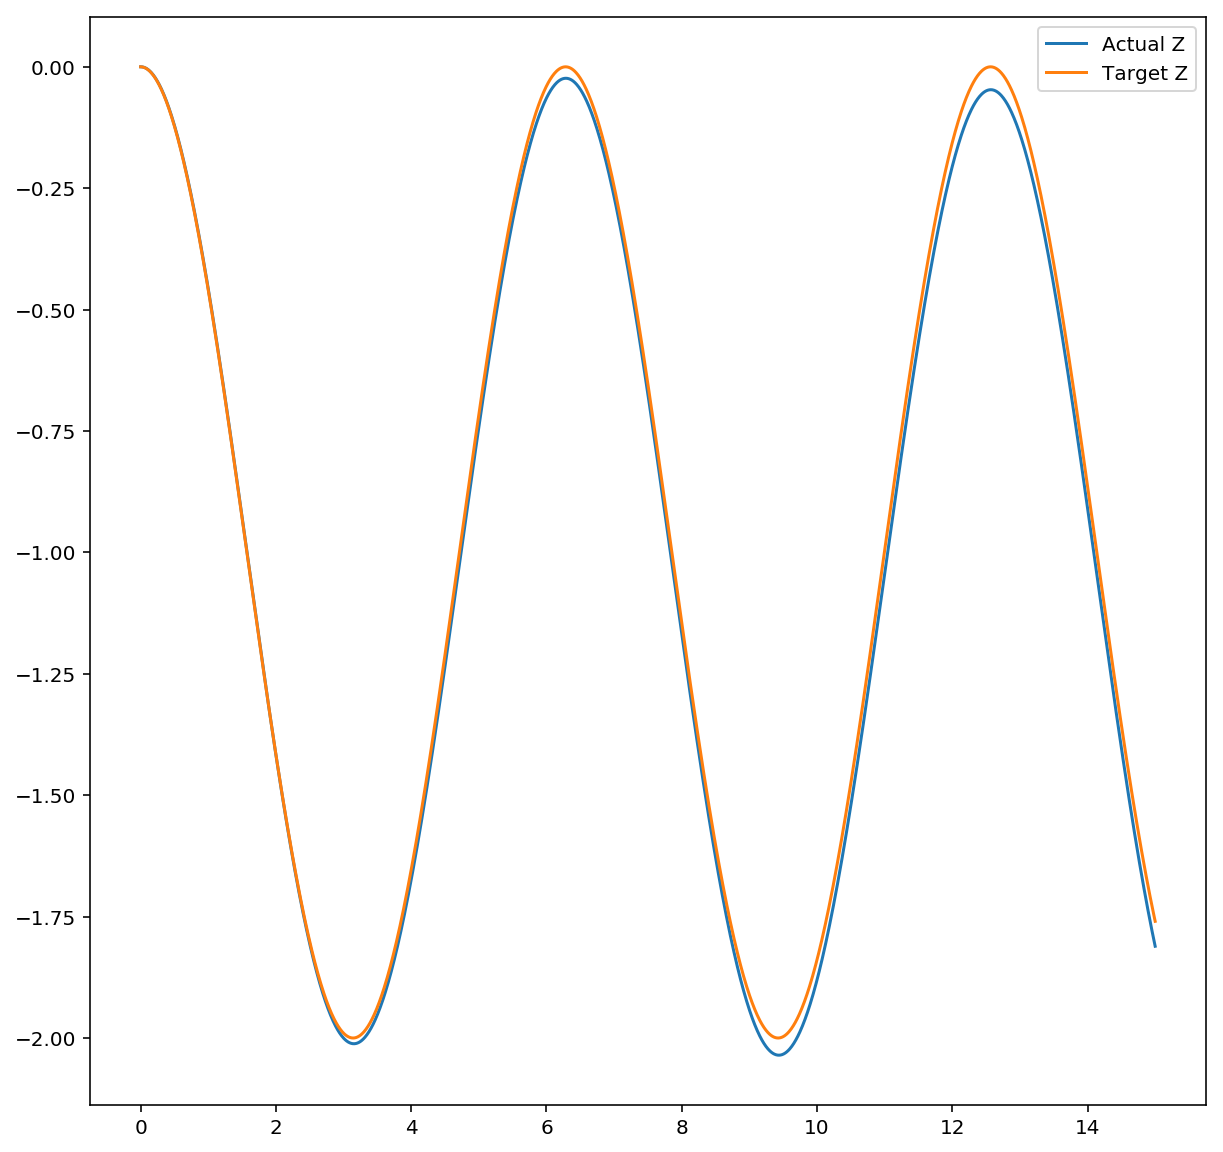

In [23]:
# If your code is working correctly then running this cell
#  should produce two oscillating plots which line up almost
#  perfectly.

t = np.linspace(0.0,15.0,2000)
target_z = np.cos(t) - 1
target_z_dot_dot = -np.cos(t)
dt = t[1] - t[0]

drone = CoaxialCopter()
z_history = []
for z_dot_dot_targ in target_z_dot_dot:
#     z_history.append(drone.z)  # this requires @property getter method
    z_history.append(drone.X[0])  # should reference state vector X
    drone.set_rotors_angular_velocities(z_dot_dot_targ, 0.0)
    drone.advance_state(dt)

plt.plot(t,z_history)
plt.plot(t, target_z)
plt.legend(["Actual Z", "Target Z"])
plt.show()